In [ ]:
%cd NYSE-Temporal-Graph-Construction

[Errno 2] No such file or directory: 'NYSE-Temporal-Graph-Construction'
/teamspace/studios/this_studio/NYSE-Temporal-Graph-Construction


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [1]:
import kagglehub
import kagglehub.datasets
import numpy as np
import pandas as pd
import networkx as nx
from functools import cache
from os.path import join as join_path
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

In [14]:
CORR_THRESHOLD = 0.232
TRAIN_RATE = 0.8

In [15]:
dataset_path = kagglehub.dataset_download("dgawlik/nyse")

In [16]:
fundamentals_pd = pd.read_csv(join_path(dataset_path,"fundamentals.csv"))
prices_pd = pd.read_csv(join_path(dataset_path, "prices.csv"))
prices_split_adjusted_df = pd.read_csv(join_path(dataset_path, "prices-split-adjusted.csv"))
securities_pd = pd.read_csv(join_path(dataset_path, "securities.csv"))

prices_split_adjusted_df.sort_values(by=['date', 'symbol'], inplace=True)

In [17]:
all_symbols = prices_pd['symbol'].sort_values().unique()

@cache
def symbol_to_int(symbol: str):
    return all_symbols.tolist().index(symbol)

@cache
def int_to_symbol(idx):
    idx = int(idx)
    return all_symbols[idx]

print("Num of symbols:", len(all_symbols))

def get_symbol_by_sector(sector):
    return securities_pd[securities_pd['GICS Sector'] == sector]['Ticker symbol'].to_list()

securities_pd.groupby('GICS Sector')['Ticker symbol'].count()

Num of symbols: 501


GICS Sector
Consumer Discretionary         85
Consumer Staples               37
Energy                         36
Financials                     64
Health Care                    59
Industrials                    69
Information Technology         68
Materials                      25
Real Estate                    29
Telecommunications Services     5
Utilities                      28
Name: Ticker symbol, dtype: int64

In [18]:
prices_split_adjusted_df['date'] = pd.to_datetime(prices_split_adjusted_df['date']).dt.date
dates = prices_split_adjusted_df['date'].sort_values().unique()

@cache
def any_to_date(date):
    if not isinstance(date, pd._libs.tslibs.timestamps.Timestamp):
        date = pd.to_datetime(date).date()
    return date

@cache
def date_to_int(date):
    date = any_to_date(date)
    return dates.tolist().index(date)

@cache
def int_to_date(idx):
    return dates[idx]

print(dates)

[datetime.date(2010, 1, 4) datetime.date(2010, 1, 5)
 datetime.date(2010, 1, 6) ... datetime.date(2016, 12, 28)
 datetime.date(2016, 12, 29) datetime.date(2016, 12, 30)]


In [19]:
data_len = len(prices_split_adjusted_df)
train_rate, test_rate = TRAIN_RATE, 1 - TRAIN_RATE

prices_split_adjusted_df['symbol'] = prices_split_adjusted_df['symbol'].apply(lambda x: symbol_to_int(x))
prices_split_adjusted_df['daily_change'] = (prices_split_adjusted_df['close'] - prices_split_adjusted_df['open']) / prices_split_adjusted_df['open'] * 100


training_df = prices_split_adjusted_df[:int(train_rate * data_len)]
test_df = prices_split_adjusted_df[int((train_rate) * data_len):]

target_df = training_df


In [20]:
record = target_df.pivot(index='date', columns='symbol', values='daily_change')

correlation_matrix = record.corr()
correlation_matrix

symbol,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
symbol,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.312910,0.313391,0.362349,0.373395,0.412581,0.382400,0.507772,0.488402,0.542574,...,0.478223,0.488481,0.566418,0.461568,0.418633,0.376441,0.428346,0.505619,0.506850,0.257444
1,0.312910,1.000000,0.238724,0.212365,0.167983,0.229716,0.203859,0.204787,0.276705,0.286424,...,0.256600,0.202704,0.302059,0.256619,0.262762,0.242383,0.265034,0.257513,0.348068,0.192633
2,0.313391,0.238724,1.000000,0.249704,0.288393,0.242341,0.197099,0.260768,0.287409,0.327769,...,0.284761,0.242890,0.303049,0.282793,0.289914,0.223783,0.355455,0.262150,0.283306,0.157218
3,0.362349,0.212365,0.249704,1.000000,0.173025,0.313280,0.239076,0.361667,0.357510,0.389586,...,0.366853,0.350046,0.330827,0.360507,0.275963,0.350872,0.367416,0.316872,0.290768,0.189781
4,0.373395,0.167983,0.288393,0.173025,1.000000,0.393133,0.387372,0.321089,0.301162,0.341577,...,0.283796,0.290968,0.346580,0.316210,0.298429,0.265990,0.228287,0.382418,0.242512,0.250621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.376441,0.242383,0.223783,0.350872,0.265990,0.337159,0.225608,0.339376,0.381809,0.378662,...,0.348725,0.325044,0.317565,0.307389,0.321764,1.000000,0.316602,0.313328,0.278743,0.170650
497,0.428346,0.265034,0.355455,0.367416,0.228287,0.347178,0.324898,0.388520,0.388988,0.409496,...,0.353203,0.397928,0.397560,0.361388,0.304557,0.316602,1.000000,0.334810,0.361461,0.187047
498,0.505619,0.257513,0.262150,0.316872,0.382418,0.413327,0.428944,0.402085,0.396753,0.411785,...,0.358040,0.442056,0.532977,0.380397,0.344901,0.313328,0.334810,1.000000,0.376008,0.212614


In [21]:
adj_matrix = correlation_matrix[correlation_matrix != 1.0]
adj_matrix.fillna(0, inplace=True)


average_corr = adj_matrix.mean().mean()
print("Average correlation:", average_corr)

adj_matrix = correlation_matrix[(correlation_matrix > 0.232) & (correlation_matrix != 1.0)]
# Replace NaN values with 0
adj_matrix = adj_matrix.fillna(0)

g: nx.Graph = nx.from_pandas_adjacency(adj_matrix)

Average correlation: 0.3440724361778559


In [22]:
wdegrees = {node:degree for node, degree in g.degree(weight='weight')}

get_node_data = lambda node: (int_to_symbol(node), wdegrees[node], sorted(list(map(lambda x: (x, int_to_symbol(x), g.get_edge_data(node, x)['weight']), g.neighbors(node))), key=lambda x: x[2], reverse=True))
print("Examples (Stock, Weighted Degrees, Sorted Neighbors):")
print(*get_node_data(symbol_to_int("GOOG")))
print(*get_node_data(symbol_to_int("AMZN")))
print(*get_node_data(symbol_to_int("AAPL")))

print("\nNodes without any neighbors:", [(node, int_to_symbol(node), d) for node, d in wdegrees.items() if d==0])


Examples (Stock, Weighted Degrees, Sorted Neighbors):
GOOG 161.11184941760817 [(202, 'GOOGL', 0.9871697714837935), (379, 'PYPL', 0.5518175513408198), (36, 'AMZN', 0.5069744368321338), (353, 'PCLN', 0.4950053922441408), (438, 'TROW', 0.4750846541408993), (3, 'AAPL', 0.47081701282552546), (223, 'HON', 0.46896806678385644), (34, 'AMP', 0.46575640163915244), (129, 'DHR', 0.46213260156358343), (11, 'ADP', 0.4607744638670308), (372, 'PRU', 0.4576419447537911), (32, 'AMG', 0.4570506680663096), (247, 'IVZ', 0.4551340741793833), (380, 'QCOM', 0.4547875437183471), (397, 'SBUX', 0.4546208868474931), (61, 'BEN', 0.4459289172135086), (257, 'KHC', 0.44548783945852843), (305, 'MMM', 0.4438170127231282), (234, 'IBM', 0.441391077600326), (163, 'ETN', 0.4404568935316798), (314, 'MSFT', 0.4398254897907639), (321, 'NAVI', 0.435930133581584), (445, 'TXN', 0.43530247241896175), (173, 'FB', 0.43528098402062126), (358, 'PFG', 0.4352614581542611), (351, 'PCAR', 0.43350364487263715), (476, 'WFC', 0.432968593740

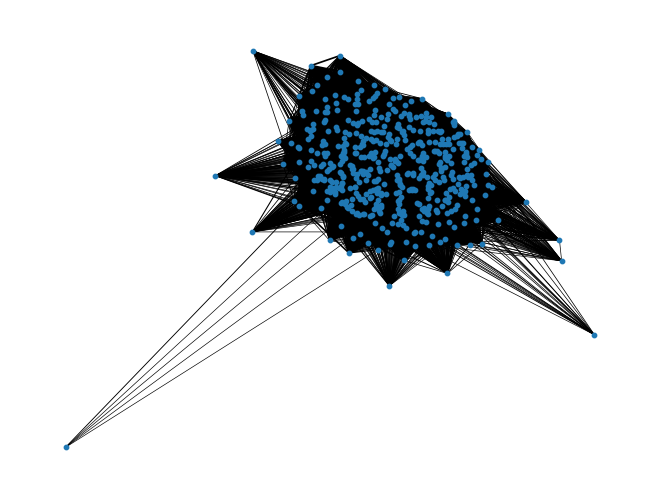

In [23]:
nx.draw(g, with_labels=False, node_size=10, width=[weight*2 for (u, v, weight) in g.edges(data='weight')])
plt.show()
print()

In [24]:
class Predictor:

    def __init__(self, g: nx.Graph):
        self.g = g

    def _aggregate(self, gc):
        agg_values = {}

        for node_id in gc.nodes:
            neighbors = list(gc.neighbors(node_id))
            sum_values, sum_weights = 0.0, 0.0
            updated = False
            for neighbor in neighbors:
                if 'value' in gc.nodes[neighbor]:
                    v = gc.nodes[neighbor]['value']
                    w = gc.get_edge_data(node_id, neighbor)['weight']
                    sum_values +=  v * w
                    sum_weights += w
                    updated = True
            if updated:
                agg_values[node_id] = sum_values / sum_weights
        
        # Update
        for node_id, value in agg_values.items():
            gc.nodes[node_id]['value'] = value
        return gc
    
    def predict(self, target, neighbors_value):
        res = 0
        sum_weights = 0
        for neighbor, neighbor_value in neighbors_value:
            if isinstance(neighbor, str):
                neighbor = symbol_to_int(neighbor)
            if neighbor not in self.g:
                continue
            w = self.g.get_edge_data(target, neighbor)['weight']
            sum_weights += w
            res += neighbor_value * w
        return res / sum_weights if sum_weights > 0 else None


    def __call__(self, node_values: dict, k=1):
        assert k >= 0
        if isinstance(node_values, tuple) or isinstance(node_values, list):
            node_values = dict(node_values)
        
        gc = self.g.copy()
        for source_node, source_value in node_values.items():
            if isinstance(source_node, str):
                source_node = symbol_to_int(source_node)
            
            if source_node not in gc.nodes: # adding unseen nodes without edge
                gc.add_node(source_node)
            gc.nodes[source_node]['value'] = source_value

        # Aggregate
        for _ in range(k):
            gc = self._aggregate(gc)
        
        gc.remove_nodes_from([node_id for node_id in gc.nodes if 'value' not in gc.nodes[node_id]])
        return gc
    
    def available_symbols(self):
        return set(self.g.nodes)
        
        
# pred = Predictor(g)
# gc = pred([("GOOG", 0.2), ("AMZN", 0.9)], 1)
# print([(n, gc.nodes[n]['value']) for n in gc.nodes])
# nx.draw(gc, with_labels=True, width=[weight*2 for (u, v, weight) in g.edges(data='weight')])
# plt.show()

# test_g = nx.Graph()
# test_g.add_node(0)
# test_g.add_node(1)
# test_g.add_node(2)
# test_g.add_node(3)
# test_g.add_node(4)

# test_g.add_edge(0, 1, weight=0.5)
# test_g.add_edge(1, 2, weight=0.5)
# test_g.add_edge(2, 3, weight=0.25)
# test_g.add_edge(3, 4, weight=0.25)

# test_pred = Predictor(test_g)
# test_gc = test_pred([(0,10), (4, 10), (80, 80)], 1)
# print([(n, test_gc.nodes[n]['value']) for n in test_gc.nodes])
# nx.draw(test_gc, with_labels=True, width=[weight*2 for (u, v, weight) in test_g.edges(data='weight')])


In [25]:
p = Predictor(g)

def evaluate(pred: Predictor, test_dataset: pd.DataFrame = test_df, random_choice_n=None):
    
    predictions = np.ndarray([len(test_dataset['date'].unique()), len(all_symbols), 2])
    i = -1
    for date, date_data in test_dataset.groupby('date'):
        i += 1
        data_symbols = set(date_data['symbol'].unique())
        final_symbols = data_symbols.intersection(pred.available_symbols())

        final_data = date_data[date_data['symbol'].isin(final_symbols)]

        node_values = final_data[['symbol','daily_change']].values.tolist()
        node_values = dict(map(lambda x: (int(x[0]), x[1]), node_values))

        if random_choice_n:
            target_list = np.random.choice(final_symbols, random_choice_n)
        else:
            target_list = final_symbols

        for target in final_symbols:
            actual = node_values[target]

            neighbor_symbols = set(pred.g.neighbors(target)).intersection(final_symbols)
            neighbor_value = [(n, node_values[n]) for n in neighbor_symbols]

            predicted = pred.predict(target, neighbor_value)
            # print(target, predicted)
            if predicted is None:
                continue
            predictions[i][target][0] = predicted
            predictions[i][target][1] = actual
            # print(predictions[i][target])
            # print(actual, predicted, target, neighbors_value)
            # se += (actual - predicted) ** 2
        # print()

        # rmse = np.sqrt(se / len(node_values))
        # r2 = 1 - (se / target_date_data['daily_change'].var())

        # yield rmse, r2
        
    return predictions
    #     print(date, square_errors[date])
    # mse = sum(square_errors.values()) / len(square_errors)
    # print(actual, predicted, target, neighbors_value)
    # square_errors[date] = square_errors.get(date, 0) + (actual - predicted) ** 2
    # rmse = np.sqrt(mse)
    # r2 = 1 - (mse / test_df['daily_change'].var())
    # return rmse, r2

df = test_df[test_df['date'].isin(test_df['date'].unique()[:])]
predictions = evaluate(p, df)

def compute_measures(predictions):
    predictions[np.isinf(predictions)] = 0 # find infs in predictions and get it out
    predictions[np.isnan(predictions)] = 0 # find infs in predictions and get it out
    var = np.var(predictions[:, :, 1], axis=None)
    se = np.square(predictions[:, :, 0] - predictions[:, :, 1])
    # se[np.isinf(se)] = 0 # find infs in predictions and get it out
    # se[np.isnan(se)] = 0 # find infs in predictions and get it out
    mse = np.mean(se, axis=None)
    print("VAR", var)
    r2 = 1 - mse / var
    return mse, r2

mse, r2 = compute_measures(predictions)

print("MSE:", mse)
print("R2:", r2)

VAR 2.441844898702855
MSE: 1.8514351773015116
R2: 0.24178837964482425
